### MRI Brain Tumour Classifier, based on Google's Mobilenetv3 Model
References:
- https://blog.research.google/2019/11/introducing-next-generation-on-device.html
- https://www.kaggle.com/models/google/mobilenet-v3/frameworks/tensorFlow2
- https://www.tensorflow.org/tutorials/images/transfer_learning
- https://www.tensorflow.org/tutorials/load_data/images

Found 480 files belonging to 4 classes.
Using 384 files for training.
Found 480 files belonging to 4 classes.
Using 96 files for validation.

Training Dataset Preview


2024-06-04 23:31:21.321360: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


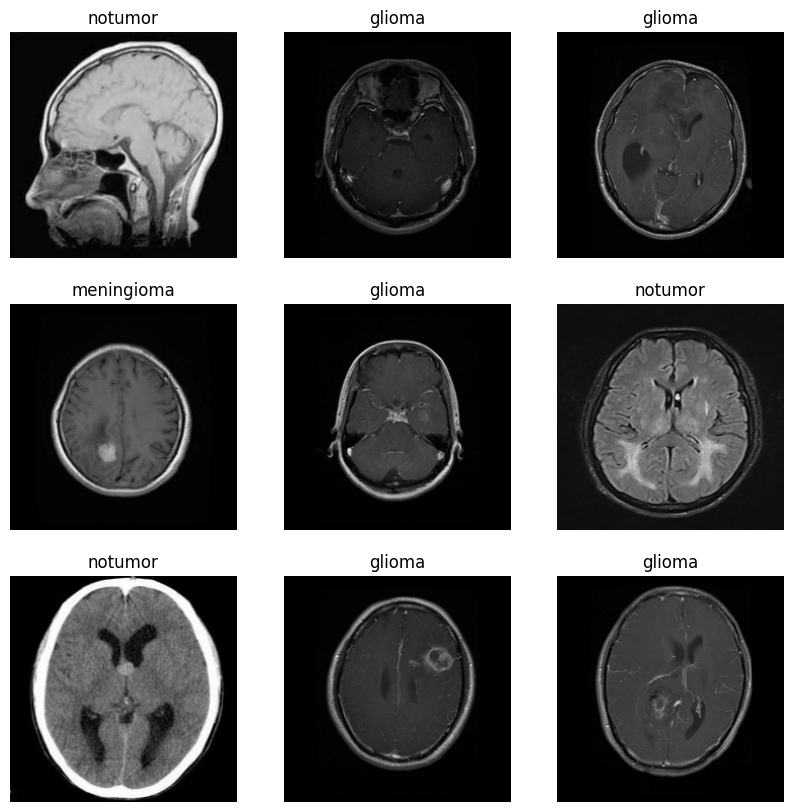

Validation Dataset Preview


2024-06-04 23:31:21.651548: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


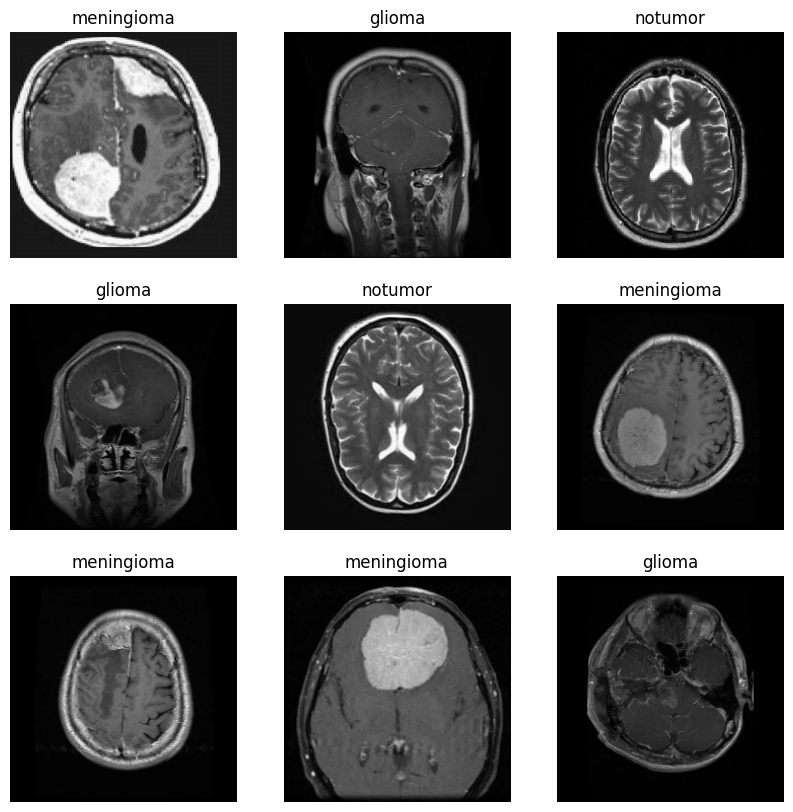

In [1]:
from utils import *

""" Dataset Preparations """
# Parameters
img_batch_size = 32
img_height = 224
img_width = 224
img_size = (img_height, img_width) # MobilenetV3 requires 224x224 input images
img_shape = img_size + (3,)

# Training dataset
train_ds = tf.keras.utils.image_dataset_from_directory(
  DATASET_FOLDER,
  validation_split=0.2,
  subset="training",
  shuffle=True,
  seed=RANDOM_STATE,
  image_size=img_size,
  batch_size=img_batch_size)

# Validation (test) dataset
val_ds = tf.keras.utils.image_dataset_from_directory(
  DATASET_FOLDER,
  validation_split=0.2,
  subset="validation",
  shuffle=True,
  seed=RANDOM_STATE,
  image_size=img_size,
  batch_size=img_batch_size)

# Get class names
class_names = train_ds.class_names
# class_names = val_ds.class_names

# Enable buffered prefetching to overlap data preprocessing and model execution during training, to speed up access to dataset
train_ds = train_ds.prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.prefetch(buffer_size=tf.data.AUTOTUNE)

# Preview datasets
print("\nTraining Dataset Preview")
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")
plt.show()

print("Validation Dataset Preview")
plt.figure(figsize=(10, 10))
for images, labels in val_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")
plt.show()    

In [2]:
""" Create classification head for transfer learning using the MobileNetV3 model """
# Input layer
inputs = keras.Input(shape=img_shape)

# Preprocessing layers
x = get_preprocessing_layers()(inputs)

# Base model layer, ensure that the model is running in inference mode
x = get_base_model(img_shape)(x, training=False) 

# Processing layers
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.Dense(1024, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.001))(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Dropout(0.3)(x)

# Output layer (use softmax for multi-label classification task)
outputs = keras.layers.Dense(len(class_names), activation='softmax')(x)

# Create model
model = keras.Model(inputs, outputs)
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

model.summary()

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential (Sequential)         │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ MobilenetV3small (Functional)   │ (None, 7, 7, 576)      │       939,120 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 576)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1024)           │       590,848 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 1024)           │         4,096 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 4)              │         4,100 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,538,164 (5.87 MB)

 Trainable params: 596,996 (2.28 MB)

 Non-trainable params: 941,168 (3.59 MB)

In [4]:
# Train model
# early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=4, restore_best_weights=True)
# history = model.fit(train_ds, validation_data=val_ds, epochs=100, callbacks=[early_stopping])
history = model.fit(train_ds, validation_data=val_ds, epochs=100)

Epoch 1/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 4s 154ms/step - accuracy: 0.5716 - loss: 1.9280 - val_accuracy: 0.5625 - val_loss: 1.6790
Epoch 2/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 115ms/step - accuracy: 0.8026 - loss: 1.2967 - val_accuracy: 0.5833 - val_loss: 1.7805
Epoch 3/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 113ms/step - accuracy: 0.8829 - loss: 1.0465 - val_accuracy: 0.6250 - val_loss: 1.6182
Epoch 4/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 112ms/step - accuracy: 0.8577 - loss: 1.0316 - val_accuracy: 0.5938 - val_loss: 1.6843
Epoch 5/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 118ms/step - accuracy: 0.8683 - loss: 1.0284 - val_accuracy: 0.6667 - val_loss: 1.5163
Epoch 6/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 116ms/step - accuracy: 0.9006 - loss: 0.9545 - val_accuracy: 0.6875 - val_loss: 1.3331
Epoch 7/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 114ms/step - accuracy: 0.9291 - loss: 0.8122 - val_accuracy: 0.6458 - val_loss: 1.5180
Epoch 8/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 118ms/step - accuracy: 0.9164 - loss: 0.8370 - val_accu

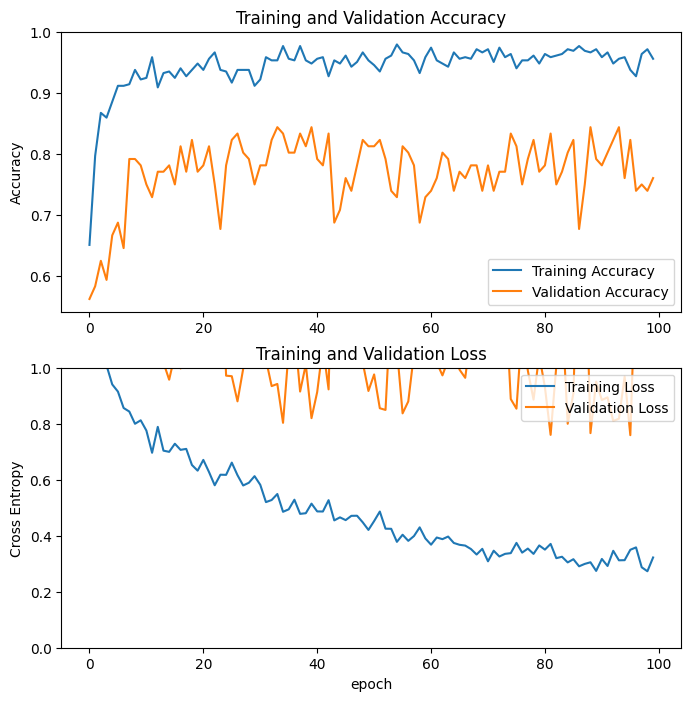

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step - accuracy: 0.7669 - loss: 1.0220
Test Accuracy : 0.7604166865348816
Test Loss : 1.1147481203079224


In [5]:
""" Preliminary Model Performance """
# View training metrics across epochs
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

# Test metrics
loss, accuracy = model.evaluate(val_ds)
print('Test Accuracy :', accuracy)
print('Test Loss :', loss)

In [6]:
""" Model Performance """
# Load images and labels
images, labels, class_names = load_data(DATASET_FOLDER)

# Load the trained model
model = keras.models.load_model(MODEL_FILE)

# Train-Test split
x_train, x_test, y_train, y_test = train_test_split(images, labels, test_size=0.2, stratify=labels, random_state=RANDOM_STATE)

# Create TensorFlow datasets
train_ds = tf.data.Dataset.from_tensor_slices((x_train, y_train)).batch(img_batch_size).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = tf.data.Dataset.from_tensor_slices((x_test, y_test)).batch(img_batch_size).prefetch(buffer_size=tf.data.AUTOTUNE)

# Initialise predictions
list_train_pred = []
list_test_pred = []
for image_path in x_train:
    list_train_pred.append(predict_class(image_path, model, class_names, (224, 224), verbose_output=1))
for image_path in x_test:
    list_test_pred.append(predict_class(image_path, model, class_names, (224, 224), verbose_output=1))
    
# Get model's training performance
print("\nTraining Performance")
training_results = classifier_metrics(list(y_train), list_train_pred, print_results=True)

# Get model's test performance
print("\nTest Performance")
test_results = classifier_metrics(list(y_test), list_test_pred, print_results=True)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 492ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━

In [ ]:
""" Model Performance on other datasets """
datasets = natsorted(os.listdir(f"{MAIN_DATASET_FOLDER}/others"))

for current_dataset in datasets:
    print(f"~ DATASET {current_dataset}~", end="\n\n")
    dataset_path = f"{MAIN_DATASET_FOLDER}/others/{current_dataset}"

    # Load images and labels
    images, labels, class_names = load_data(dataset_path)

    # Load the trained model
    model = keras.models.load_model(MODEL_FILE)

    # Train-Test split
    x_train, x_test, y_train, y_test = train_test_split(images, labels, test_size=0.2, stratify=labels, random_state=1234)

    # Create TensorFlow datasets
    train_ds = tf.data.Dataset.from_tensor_slices((x_train, y_train)).batch(img_batch_size).prefetch(buffer_size=tf.data.AUTOTUNE)
    val_ds = tf.data.Dataset.from_tensor_slices((x_test, y_test)).batch(img_batch_size).prefetch(buffer_size=tf.data.AUTOTUNE)

    # Initialise predictions
    list_train_pred = []
    list_test_pred = []
    for image_path in x_train:
        list_train_pred.append(predict_class(image_path, model, class_names, (224, 224), verbose_output=0))
    for image_path in x_test:
        list_test_pred.append(predict_class(image_path, model, class_names, (224, 224), verbose_output=0))
    
    # Get model's training performance
    print("TRAINING PERFORMANCE")
    training_results = classifier_metrics(list(y_train), list_train_pred, print_results=True)

    # Get model's test performance
    print("TEST PERFORMANCE")
    test_results = classifier_metrics(list(y_test), list_test_pred, print_results=True)

In [7]:
""" Model performance on original full dataset """
# Load images and labels
train_images, train_labels, train_class_names = load_data(f"{MAIN_DATASET_FOLDER}/full/Training")
test_images, test_labels, test_class_names = load_data(f"{MAIN_DATASET_FOLDER}/full/Testing")

# Load the trained model
model = keras.models.load_model(MODEL_FILE)

# Create TensorFlow datasets
train_ds = tf.data.Dataset.from_tensor_slices((train_images, train_labels)).batch(img_batch_size).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = tf.data.Dataset.from_tensor_slices((test_images, test_labels)).batch(img_batch_size).prefetch(buffer_size=tf.data.AUTOTUNE)

# Initialise predictions
list_train_pred = []
list_test_pred = []
for image_path in train_images:
    list_train_pred.append(predict_class(image_path, model, class_names, (224, 224), verbose_output=0))
for image_path in test_images:
    list_test_pred.append(predict_class(image_path, model, class_names, (224, 224), verbose_output=0))

# Get model's training performance
print("TRAINING PERFORMANCE")
training_results = classifier_metrics(list(train_labels), list_train_pred, print_results=True)

# Get model's test performance
print("TEST PERFORMANCE")
test_results = classifier_metrics(list(test_labels), list_test_pred, print_results=True)

TRAINING PERFORMANCE
Accuracy: 0.7657563025210085
Precision: 0.7768669705126684
Recall: 0.7662185622706243
F1 Score: 0.7647022439543838
Matthews Correlation Coefficient (MCC): 0.6919621637888398
Cohen's Kappa: 0.688329813853199
Hamming Loss: 0.2342436974789916

Confusion Matrix:
 [[1099  170    7   45]
 [ 225  867   16  231]
 [ 125  297 1133   40]
 [  35  147    0 1275]]

Classification Report:
               precision    recall  f1-score   support

      glioma       0.74      0.83      0.78      1321
  meningioma       0.59      0.65      0.61      1339
     notumor       0.98      0.71      0.82      1595
   pituitary       0.80      0.88      0.84      1457

    accuracy                           0.77      5712
   macro avg       0.78      0.77      0.76      5712
weighted avg       0.79      0.77      0.77      5712


TEST PERFORMANCE
Accuracy: 0.7467581998474447
Precision: 0.7682553138384072
Recall: 0.7564324618736383
F1 Score: 0.7501443544490339
Matthews Correlation Coefficient 

In [ ]:
# Export model
# model.save(MODEL_FILE)